In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from skimage.metrics import structural_similarity as ssim
import scipy.ndimage as ndi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss

from plotly_resampler.aggregation import MinMaxAggregator
from agg_utils.data_hepers import get_png_path, get_series
from agg_utils.fig_construction import return_matplotlib_arr

# Testing the or conv mask

In the snippets below, we will:

- compute the SSIM (and DSSIM)
- compute the or conv mask based on the delta between the non-aggregated and aggregated figure
- verify whether the SSIM resides within this or-conv mask



## Using `matplotlib` figures

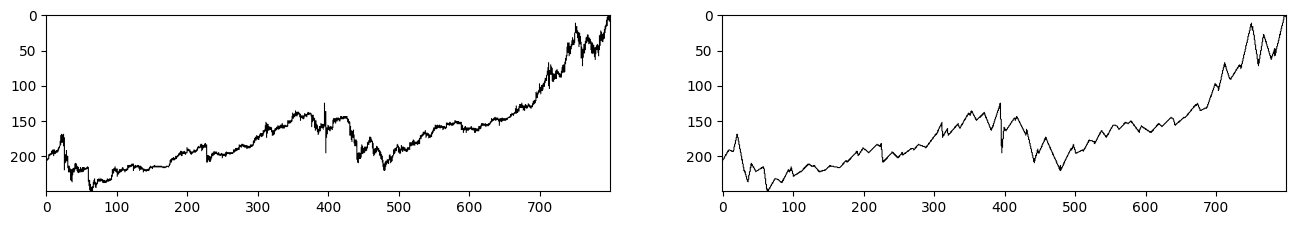

In [3]:
vis_dict = {
    "toolkit": "matplotlib",
    "data": "btc",
    "n": 200_000,
    "n_out": 200,
    "aggregator": "M4Aggregator",
    "line_width": 1,
    "line_shape": "default",
    "aa": False,
}
path = get_png_path(**vis_dict)
# print(path, path.exists())

ref_dict = vis_dict.copy()
ref_dict["aggregator"] = "reference"
# Select an aggregation method from the dataframe
fig, axs = plt.subplots(1, 2, figsize=(8 * 2, 4))
axs[0].imshow(plt.imread(get_png_path(**ref_dict)))
axs[1].imshow(plt.imread(get_png_path(**vis_dict)))
plt.show()


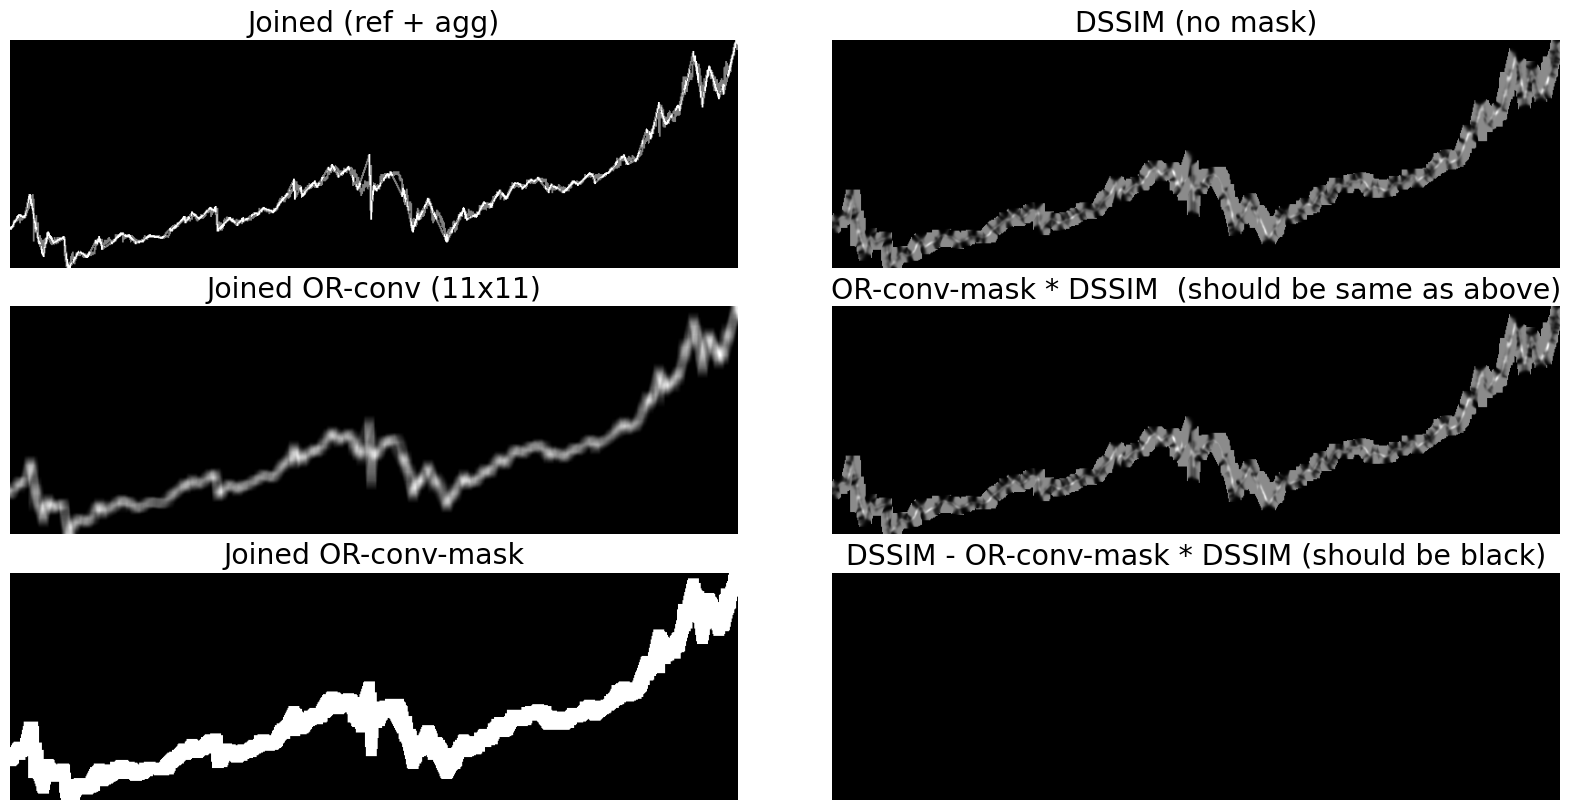

In [4]:
win_size = 11
dim = 3

# load the images
agg = 255 * plt.imread(get_png_path(**vis_dict))
ref = 255 * plt.imread(get_png_path(**ref_dict))
joined = agg[:, :, dim] + ref[:, :, dim]

# compute the ssim and derive the DSSIM
ssim_out: np.ndarray = ssim(
    ref[:, :, dim], agg[:, :, dim], gradient=False, full=True, win_size=win_size, gaussian_weights=True
)[1]
DSSIM = (1 - ssim_out) / 2

# compute the or conv and the mask
or_conv_orig = ss.convolve2d(joined, np.ones((win_size, win_size)), mode="same") != 0
# or_conv_mask = or_conv != 0
# The above 2d conv is equivalent to applying the following 1d convs
# which is ~15x faster than the 2d conv
out = ndi.convolve1d(joined, np.ones(win_size), axis=0, mode="reflect")
or_conv = ndi.convolve1d(out, np.ones(win_size), axis=1, mode="reflect")
or_conv_mask = or_conv > 0

assert np.allclose(or_conv_mask, or_conv_orig)

# Visualize the results
# set the font-size of the titles
plt.rcParams.update({"font.size": 17})
fig, axs = plt.subplots(3, 2, figsize=(10 * 2, 5 * 2))
# remove all the frames and axes
for ax in axs.flatten():
    ax.axis("off")
    ax.set_frame_on(False)
axs[0, 0].imshow(joined, cmap="gray")
axs[0, 0].set_title("Joined (ref + agg)")
axs[1, 0].imshow(or_conv, cmap="gray")
axs[1, 0].set_title("Joined OR-conv (11x11)")
axs[2, 0].imshow(or_conv_mask, cmap="gray")
axs[2, 0].set_title("Joined OR-conv-mask")
axs[0, 1].imshow(DSSIM, cmap="gray")
axs[0, 1].set_title("DSSIM (no mask)")
axs[1, 1].imshow(or_conv_mask * DSSIM, cmap="gray")
axs[1, 1].set_title("OR-conv-mask * DSSIM  (should be same as above)")
axs[2, 1].imshow(DSSIM - or_conv_mask * DSSIM, cmap="gray", vmin=0, vmax=1)
axs[2, 1].set_title("DSSIM - OR-conv-mask * DSSIM (should be black)")
plt.subplots_adjust(wspace=0.13, hspace=0.12)
plt.show()


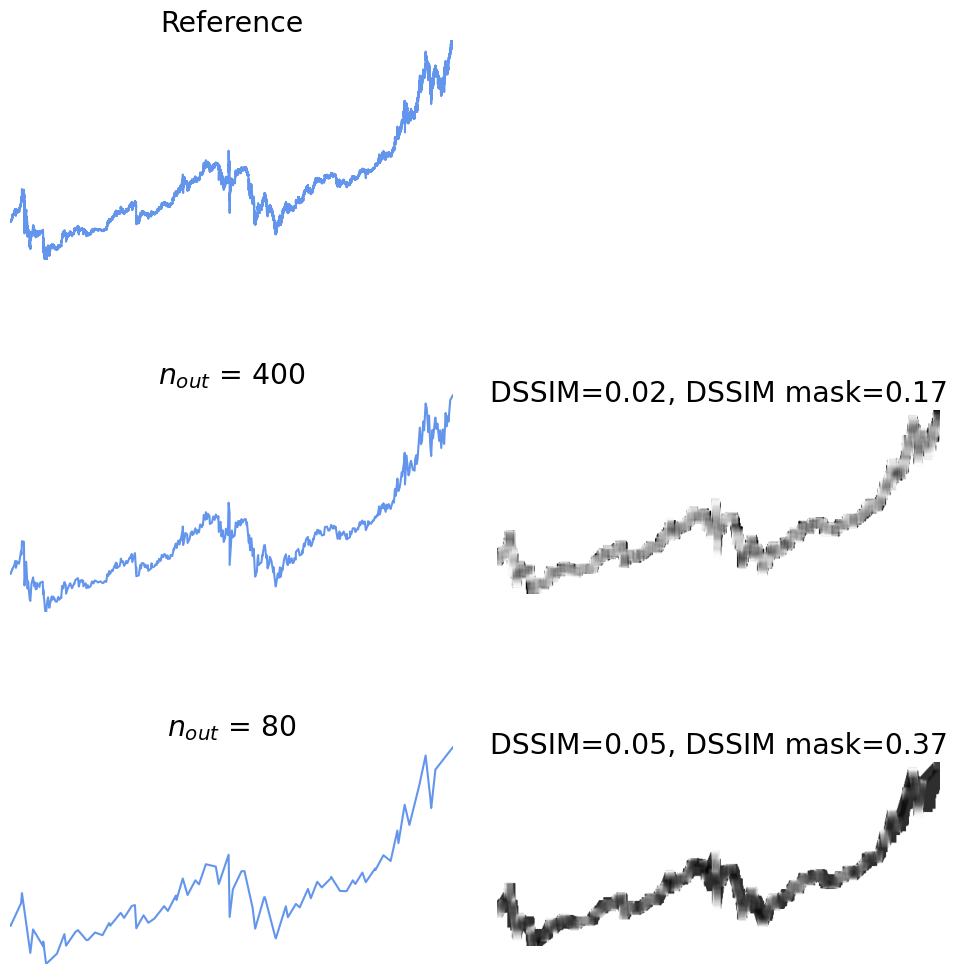

In [7]:
reference = get_series(**ref_dict)
xlim = (reference.index[0], reference.index[-1])
ylim = (reference.min(), reference.max())
matrix_width = 600
ref_mpl_arr = return_matplotlib_arr(
    reference.index, reference.values, width=matrix_width, xlim=xlim, ylim=ylim
)

ns = [400, 80]
fig, axs = plt.subplots(len(ns) + 1, 2, figsize=(12, 4 * (len(ns) + 1)))
axs[0, 0].plot(reference, color="#6495ED")
axs[0, 0].set_title("Reference")
axs[0, 0].set_xlim(xlim)
axs[0, 0].set_ylim(ylim)
axs[0, 0].set_frame_on(False)
axs[0, 0].axis("off")
# center the above subplot on the first row
axs[0, 0].set_position([0.5 - 0.5 * 0.8, 0.5 + 0.5 * 0.8, 0.8, 0.8])

axs[0, 1].axis("off")

for i, n in enumerate(ns, 1):
    if n == 0:
        agg = pd.Series()
    else:
        agg = MinMaxAggregator(interleave_gaps=False)._aggregate(reference, n)

    axs[i, 0].plot(agg, color="#6495ED")
    axs[i, 0].set_title("Reference")
    axs[i, 0].set_xlim(xlim)
    axs[i, 0].set_ylim(ylim)
    axs[i, 0].set_frame_on(False)
    axs[i, 0].axis("off")

    agg_mpl_arr = return_matplotlib_arr(
        agg.index, agg.values, width=matrix_width, xlim=xlim, ylim=ylim
    )

    ssim_out: np.ndarray = ssim(
        ref_mpl_arr[:, :, dim],
        agg_mpl_arr[:, :, dim],
        gradient=False,
        full=True,
        win_size=win_size,
        gaussian_weights=False,
    )[1]
    DSSIM = (1 - ssim_out) / 2
    axs[i, 1].imshow(DSSIM, cmap="gray_r")
    axs[i, 1].frameon = False
    axs[i, 1].axis("off")
    axs[i, 0].set_title("$n_{out}$ = " f"{n:,}")

    joined = agg_mpl_arr[:, :, dim] + ref_mpl_arr[:, :, dim]
    out = ndi.convolve1d(joined, np.ones(win_size), axis=0, mode="reflect")
    or_conv = ndi.convolve1d(out, np.ones(win_size), axis=1, mode="reflect")
    or_conv_mask = or_conv > 0

    mean_dssim = DSSIM.mean().round(2)
    mean_dssim_masked = DSSIM.ravel()[or_conv_mask.ravel()].mean().round(2)
    axs[i, 1].set_title(f"DSSIM={mean_dssim}, DSSIM mask={mean_dssim_masked}")

plt.subplots_adjust(wspace=0.1, hspace=0.6)
plt.show()
fig.savefig("dssim_conv_example.pdf")


## Using `plotly` figures

/media/tsagg_figs/plotly/LTTB_btc_1000000_400_ls=linear_lw=1.png True


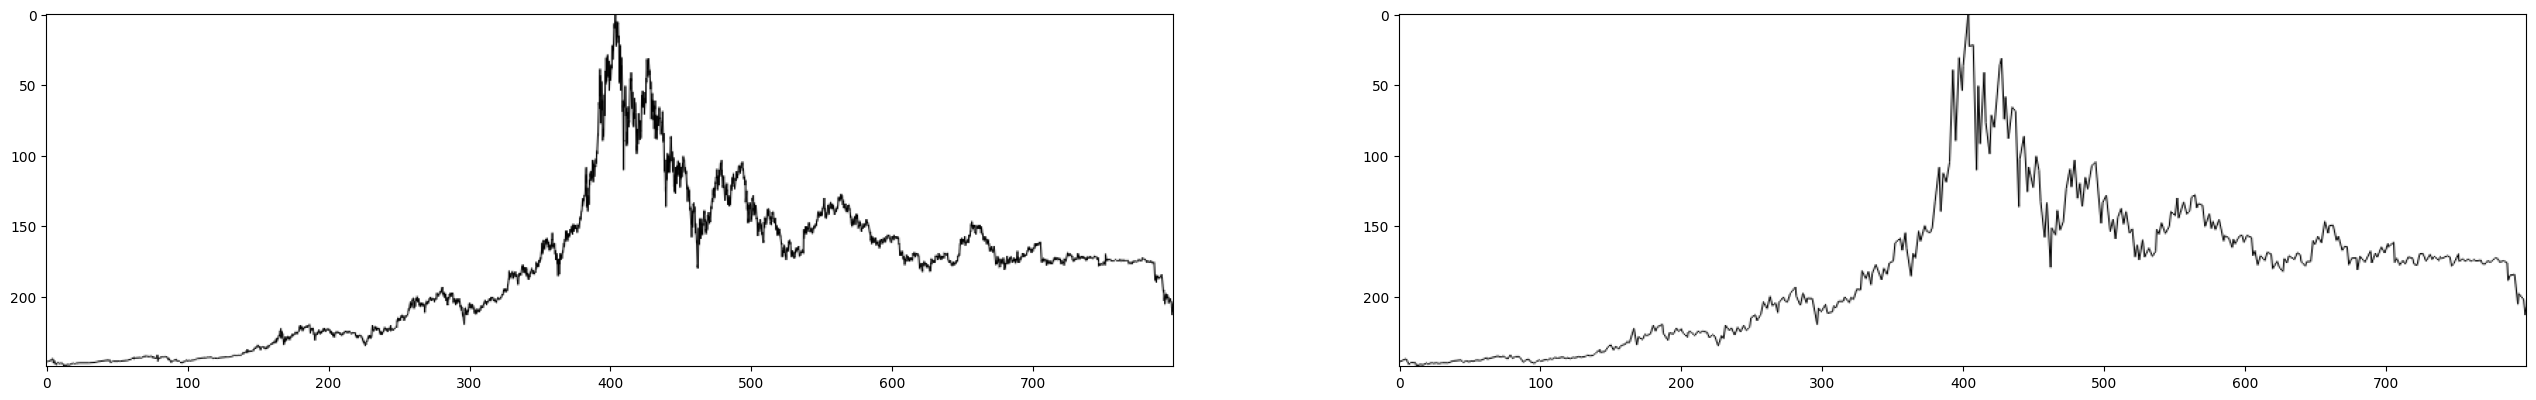

In [3]:
vis_dict = {
    "toolkit": "plotly",
    "data": "btc",
    "n": 1_000_000,
    "n_out": 400,
    "aggregator": "LTTB",
    "line_width": 1,
    "line_shape": "linear",
    "aa": False,
}
path = get_png_path(**vis_dict)
print(path, path.exists())

ref_dict = vis_dict.copy()
ref_dict["aggregator"] = "reference"
# Select an aggregation method from the dataframe
fig, axs = plt.subplots(1, 2, figsize=(16 * 2, 6))
axs[0].imshow(plt.imread(get_png_path(**ref_dict)))
axs[1].imshow(plt.imread(get_png_path(**vis_dict)))
plt.show()


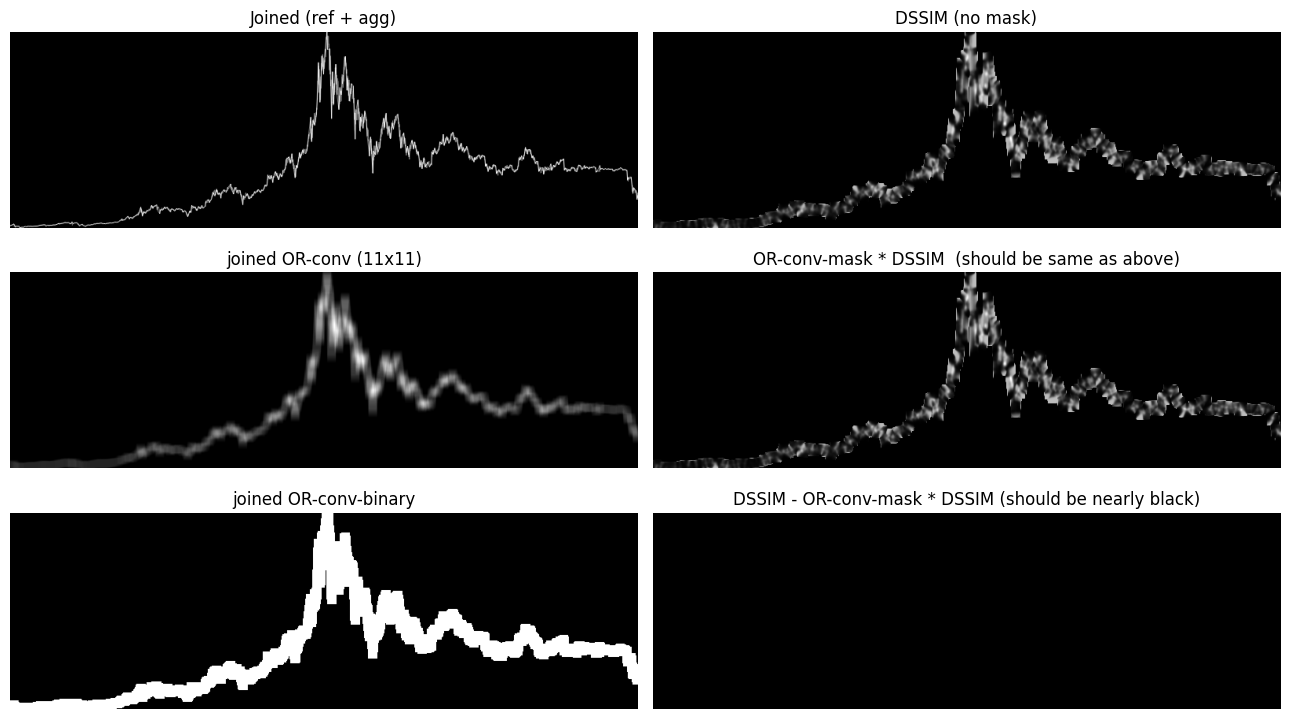

In [7]:
win_size = 11
dim = 1

# Load the images
agg = 255 - 255 * plt.imread(get_png_path(**vis_dict))
ref = 255 - 255 * plt.imread(get_png_path(**ref_dict))
joined = agg[:, :, dim] + ref[:, :, dim]

# Compute the ssim and derive the DSSIM
ssim_out: np.ndarray = ssim(
    ref[:, :, dim],
    agg[:, :, dim],
    gradient=False,
    full=True,
    win_size=win_size,
    gaussian_weights=True,
)[1]
DSSIM = (1 - ssim_out) / 2

# Compute the or conv and the mask
or_conv = ss.convolve2d(joined, np.ones((win_size, win_size)), mode="same")
or_conv_mask = or_conv != 0

# Visualize the results
fig, axs = plt.subplots(3, 2, figsize=(13, 5 * 1.5))
for ax in axs.ravel():
    ax.axis("off")
axs[0, 0].imshow(joined, cmap="gray")
axs[0, 0].set_title("Joined (ref + agg)")
axs[1, 0].imshow(or_conv, cmap="gray")
axs[1, 0].set_title("joined OR-conv (11x11)")
axs[2, 0].imshow(or_conv_mask, cmap="gray")
axs[2, 0].set_title("joined OR-conv-binary")
axs[0, 1].imshow(DSSIM, cmap="gray")
axs[0, 1].set_title("DSSIM (no mask)")
axs[1, 1].imshow(or_conv_mask * DSSIM, cmap="gray")
axs[1, 1].set_title("OR-conv-mask * DSSIM  (should be same as above)")
axs[2, 1].imshow(DSSIM - or_conv_mask * DSSIM, cmap="gray", vmin=0, vmax=1)
axs[2, 1].set_title("DSSIM - OR-conv-mask * DSSIM (should be nearly black)")
plt.tight_layout()
plt.show()
